# Processing ERA5 data in NetCDF Format

This notebook demonstrates how to work with the ECMWF ERA5 reanalysis available as part of the AWS Public Dataset Program (https://registry.opendata.aws/ecmwf-era5/).

This notebook utilizes Amazon SageMaker & AWS Fargate for providing an environment with a Jupyter notebook and Dask cluster. There is an example AWS CloudFormation template available at https://github.com/awslabs/amazon-asdi/tree/main/examples/dask for quickly creating this environment in your own AWS account to run this notebook.

## Python Imports

In [1]:
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import s3fs
import fsspec
import dask
from dask.distributed import performance_report, Client, progress

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

Install extra software here, if necessary

In [2]:
#import sys
#!{sys.executable} -m pip install graphviz
#import graphviz

## Set up the Dask Client to talk to our Fargate Dask Distributed Cluster

You will need to update the `cluster=` option in the comamnd below to make your cluster name from above

In [3]:
ecs = boto3.client('ecs')
resp = ecs.list_clusters()
clusters = resp['clusterArns']
cluster = clusters[0]

if len(clusters) > 1:
    for c in clusters:
        if c.endswith('Fargate-Dask-Cluster'):
            cluster = c
    print("Please check the cluster name and manually set it to match your environment if necessary")

#cluster="dask-Fargate-Dask-Cluster"
cluster

'arn:aws:ecs:us-east-1:282832549180:cluster/dask-202206-Fargate-Dask-Cluster'

Start the dask scheduler container through ECS and connect to it.  Note, the dashboard address displayed here is a private address that you won't be able to connect to - the public address is revealled in the following step.

In [4]:
ecs.update_service(cluster=cluster, service='Dask-Scheduler', desiredCount=1)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Scheduler'])

The following will identify the public IP address of the Dask-Scheduler task (based on security group membership) and output the dashboard URL:

In [5]:
ec2 = boto3.client('ec2')
resp = ec2.describe_network_interfaces(
  Filters=[{
      'Name': 'group-name',
      'Values': ['DaskSchedulerSecurityGroup']
  }])
schedulerurl = 'http://' + resp['NetworkInterfaces'][0]['Association']['PublicDnsName'] + ':8787/status'
from IPython.display import display,HTML
display(HTML('Dask scheduler URL: <a href=\'' + schedulerurl + '\'>' + schedulerurl + '</a>'))

### Scale out Dask Workers and connect
Start the dask worker tasks and connect to the scheduler

In [6]:
numWorkers=12
ecs.update_service(cluster=cluster, service='Dask-Worker', desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Worker'])

In [7]:
client = Client('Dask-Scheduler.local-dask:8786')
client

<Client: 'tcp://10.10.1.189:8786' processes=12 threads=24, memory=78.23 GiB>

## Open an Example File and Check the Native Chunking

Browse the dataset to discover its structure and chunking layout.  We want to chunk in an aligned way for maximum performance.

In [8]:
fs = s3fs.S3FileSystem(anon=True)
fs.ls('era5-pds/2021/01/data')

['era5-pds/2021/01/data/air_pressure_at_mean_sea_level.nc',
 'era5-pds/2021/01/data/air_temperature_at_2_metres.nc',
 'era5-pds/2021/01/data/air_temperature_at_2_metres_1hour_Maximum.nc',
 'era5-pds/2021/01/data/air_temperature_at_2_metres_1hour_Minimum.nc',
 'era5-pds/2021/01/data/dew_point_temperature_at_2_metres.nc',
 'era5-pds/2021/01/data/eastward_wind_at_100_metres.nc',
 'era5-pds/2021/01/data/eastward_wind_at_10_metres.nc',
 'era5-pds/2021/01/data/integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation.nc',
 'era5-pds/2021/01/data/lwe_thickness_of_surface_snow_amount.nc',
 'era5-pds/2021/01/data/northward_wind_at_100_metres.nc',
 'era5-pds/2021/01/data/northward_wind_at_10_metres.nc',
 'era5-pds/2021/01/data/precipitation_amount_1hour_Accumulation.nc',
 'era5-pds/2021/01/data/sea_surface_temperature.nc',
 'era5-pds/2021/01/data/sea_surface_wave_from_direction.nc',
 'era5-pds/2021/01/data/sea_surface_wave_mean_period.nc',
 'era5-pds/2021/01/data/s

In [9]:
url = 's3://era5-pds/2021/01/data/air_temperature_at_2_metres.nc'
ncfile = fsspec.open(url)
ds = xr.open_dataset(ncfile.open())

ds.air_temperature_at_2_metres.encoding

{'chunksizes': (24, 100, 100),
 'fletcher32': False,
 'shuffle': True,
 'zlib': True,
 'complevel': 4,
 'source': '<File-like object S3FileSystem, era5-pds/2021/01/data/air_temperature_at_2_metres.nc>',
 'original_shape': (744, 721, 1440),
 'dtype': dtype('<f4'),
 '_FillValue': 9.96921e+36}

In [10]:
ds.air_temperature_at_2_metres

<xarray.DataArray 'air_temperature_at_2_metres' (time0: 744, lat: 721, lon: 1440)>
[772450560 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time0    (time0) datetime64[ns] 2021-01-01 ... 2021-01-31T23:00:00
Attributes:
    least_significant_digit:  1
    standard_name:            air_temperature
    units:                    K
    long_name:                2 metre temperature
    nameECMWF:                2 metre temperature
    shortNameECMWF:           2t
    nameCDM:                  2_metre_temperature_surface
    product_type:             analysis

In [11]:
print('file size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

file size in GB 3.09



## Open 2-m air temperature as a single dataset
This is where the real work begins.  We start by defining the set of S3 objects that we are going to process, which is done using the dask s3fs module and a file pattern.

In [12]:
start_year = 2021
end_year = 2021
years = list(np.arange(start_year, end_year+1, 1))
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
file_pattern = 's3://era5-pds/{year}/{month}/data/air_temperature_at_2_metres.nc'

@dask.delayed
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    return fs.open(path)

files_mapper = [s3open(file_pattern.format(year=year,month=month)) for year in years for month in months]

Now initialise the xarray dataset

In [13]:
%%time

ds = xr.open_mfdataset(files_mapper, engine='h5netcdf', chunks={'lon':200,'lat':200,'time0':372}, concat_dim='time0', combine='nested', coords='minimal', compat='override', parallel=True)

CPU times: user 211 ms, sys: 177 ms, total: 388 ms
Wall time: 1.7 s


In [14]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info

ds size in GB 36.38



<bound method Dataset.info of <xarray.Dataset>
Dimensions:                      (lon: 1440, lat: 721, time0: 8760)
Coordinates:
  * lon                          (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * lat                          (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * time0                        (time0) datetime64[ns] 2021-01-01 ... 2021-1...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 dask.array<chunksize=(372, 200, 200), meta=np.ndarray>
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    title:        ERA5 forecasts>

The `ds.info` output above shows us that there are four dimensions to the data: lat, lon, and time0; and two data variables: air_temperature_at_2_metres, and air_pressure_at_mean_sea_level.

In [15]:
ds.air_temperature_at_2_metres

,Array,Chunk
Bytes,33.88 GiB,56.76 MiB
Shape,"(8760, 721, 1440)","(372, 200, 200)"
Count,1548 Tasks,768 Chunks
Type,float32,numpy.ndarray


## Read all data into dask worker memory
The following line reads the entire data set into worker memory.  This step is unnecessary at this stage, but it will make all subsequent calculations much faster and is a useful illustration of how dask works.  Otherwise, calculations are done without reading all data into worker memory at once, and data will need to be read back in for each calculation (taking much longer!).  

In [16]:
ds = client.persist(ds)
progress(ds)

VBox()

Sometimes data isn't evenly distributed, depending on the dataset and chunk size that we selected.  Here we rebalance the data across workers so that future tasks will make best use of cluster resources.

In [17]:
client.rebalance()

## Convert units to C from K
This performs a simple subtraction operation, to convert the temperature unit into Celcius.

In [18]:
ds['air_temperature_at_2_metres'] = (ds.air_temperature_at_2_metres - 273.15)
ds.air_temperature_at_2_metres.attrs['units'] = 'C'
ds.air_temperature_at_2_metres

,Array,Chunk
Bytes,33.88 GiB,56.76 MiB
Shape,"(8760, 721, 1440)","(372, 200, 200)"
Count,1536 Tasks,768 Chunks
Type,float32,numpy.ndarray


Perform this calculation immediately using the dataset that is already loaded in worker memory

In [19]:
ds = client.persist(ds)
progress(ds)

VBox()

## Calculate the mean 2-m air temperature for all times

In [20]:
# calculates the mean along the time dimension
temp_mean = ds['air_temperature_at_2_metres'].mean(dim='time0')

The expressions above didn’t actually compute anything. They just build the dask task graph. To do the computations, we call the `persist` method below.

In [21]:
temp_mean

<xarray.DataArray 'air_temperature_at_2_metres' (lat: 721, lon: 1440)>
dask.array<mean_agg-aggregate, shape=(721, 1440), dtype=float32, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0

In [22]:
temp_mean = temp_mean.persist()
progress(temp_mean)

VBox()

## Plot Average Surface Temperature
To plot data, we need to read it back into the local notebook python environment.  This is done using the "compute" function.  Once the data is back in local memory, we can use matplotlib to display it visually.  For more information refer to: https://distributed.dask.org/en/latest/manage-computation.html

Text(0.5, 1.0, '2021 Mean 2-m Air Temperature')

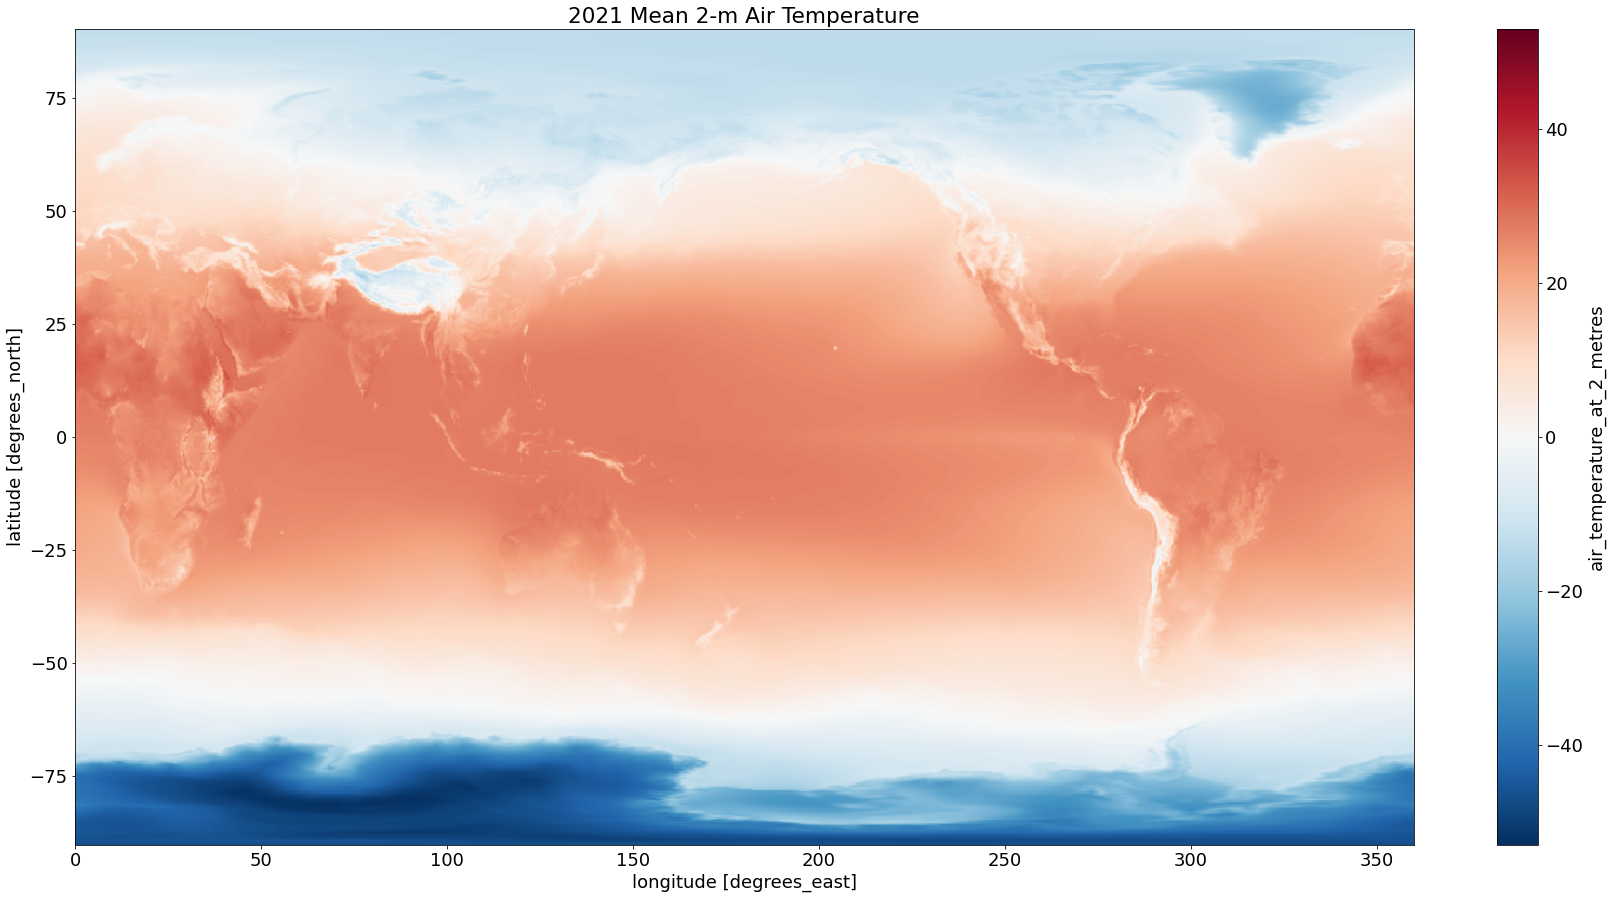

In [23]:
temp_mean.compute()
temp_mean.plot(figsize=(30, 15))
plt.title('2021 Mean 2-m Air Temperature')

## Repeat for standard deviation
The data is in memory, so let's do another calculation!

In [24]:
temp_std = ds['air_temperature_at_2_metres'].std(dim='time0')
temp_std

<xarray.DataArray 'air_temperature_at_2_metres' (lat: 721, lon: 1440)>
dask.array<_sqrt, shape=(721, 1440), dtype=float32, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0

In [25]:
temp_std = temp_std.persist()
progress(temp_std)

VBox()

Text(0.5, 1.0, '2021 Standard Deviation 2-m Air Temperature')

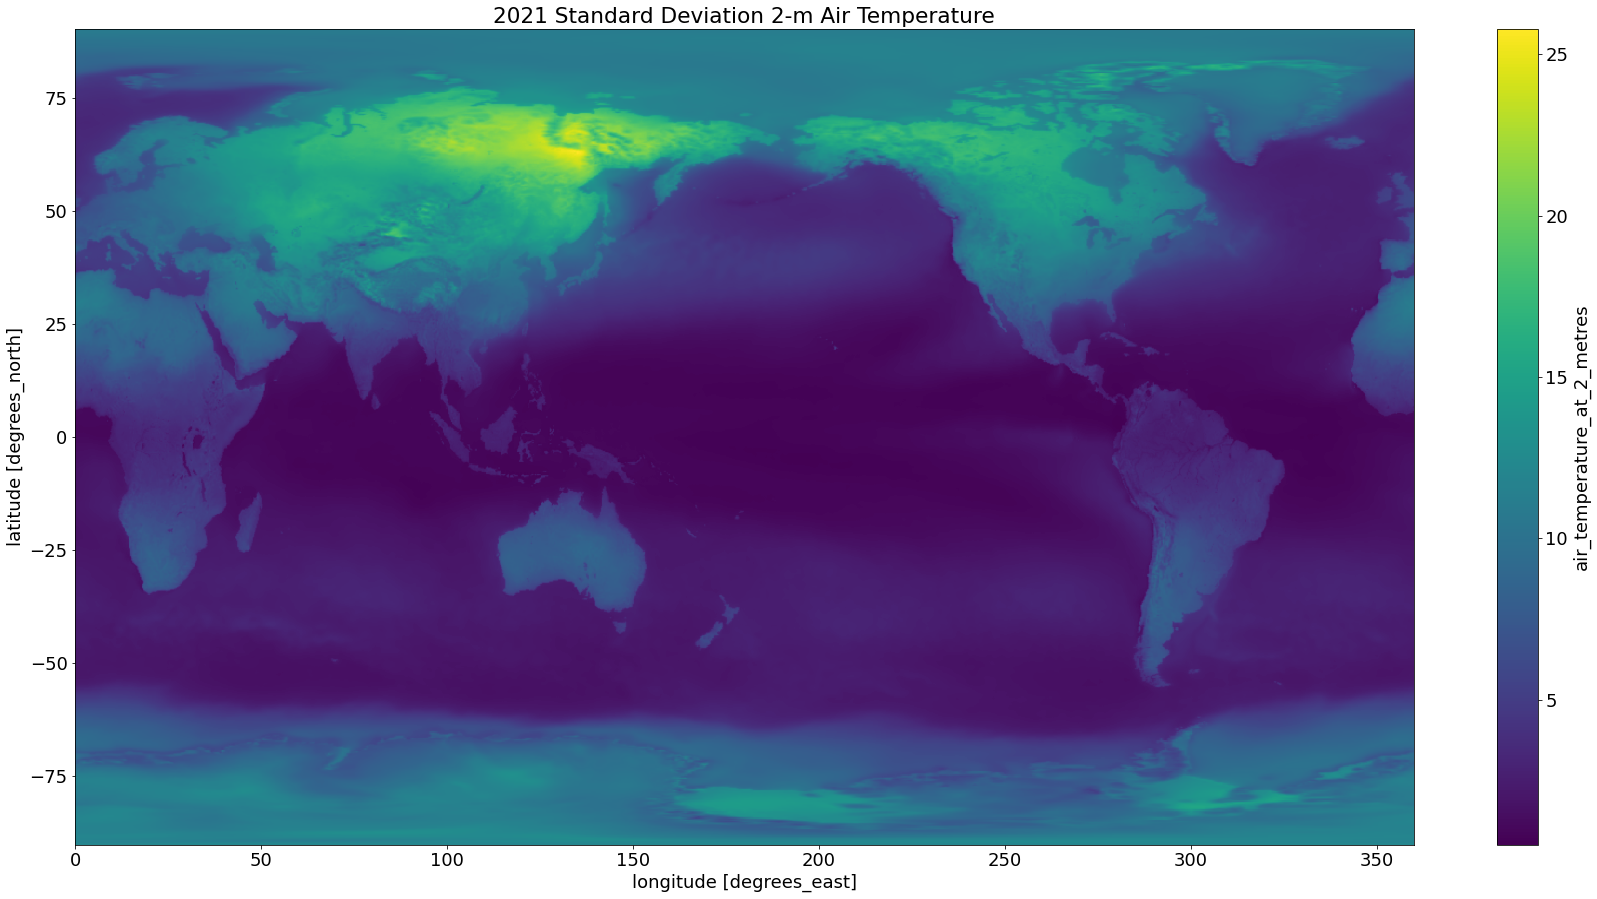

In [26]:
temp_std.compute()
temp_std.plot(figsize=(30, 15))
plt.title('2021 Standard Deviation 2-m Air Temperature')

## Plot temperature time series for points
This example creates a dataframe table of data for some specific locations defined in the array below

In [27]:
# location coordinates
locs = [
    {'name': 'Santa Barbara', 'lon': -119.70, 'lat': 34.42},
    {'name': 'Colorado Springs', 'lon': -104.82, 'lat': 38.83},
    {'name': 'Honolulu', 'lon': -157.84, 'lat': 21.29},
    {'name': 'Seattle', 'lon': -122.33, 'lat': 47.61},
    {'name': 'Melbourne', 'lon': 144.95, 'lat': -37.84},
]

# convert westward longitudes to degrees east
for l in locs:
    if l['lon'] < 0:
        l['lon'] = 360 + l['lon']
locs

[{'name': 'Santa Barbara', 'lon': 240.3, 'lat': 34.42},
 {'name': 'Colorado Springs', 'lon': 255.18, 'lat': 38.83},
 {'name': 'Honolulu', 'lon': 202.16, 'lat': 21.29},
 {'name': 'Seattle', 'lon': 237.67000000000002, 'lat': 47.61},
 {'name': 'Melbourne', 'lon': 144.95, 'lat': -37.84}]

In [28]:
ds_locs = xr.Dataset()
air_temp_ds = ds

# interate through the locations and create a dataset
# containing the temperature values for each location
for l in locs:
    name = l['name']
    lon = l['lon']
    lat = l['lat']
    var_name = name

    ds2 = air_temp_ds.sel(lon=lon, lat=lat, method='nearest')

    lon_attr = '%s_lon' % name
    lat_attr = '%s_lat' % name

    ds2.attrs[lon_attr] = ds2.lon.values.tolist()
    ds2.attrs[lat_attr] = ds2.lat.values.tolist()
    ds2 = ds2.rename({'air_temperature_at_2_metres' : var_name}).drop(('lat', 'lon'))

    ds_locs = xr.merge([ds_locs, ds2])

ds_locs.data_vars

Data variables:
    Santa Barbara     (time0) float32 dask.array<chunksize=(372,), meta=np.ndarray>
    Colorado Springs  (time0) float32 dask.array<chunksize=(372,), meta=np.ndarray>
    Honolulu          (time0) float32 dask.array<chunksize=(372,), meta=np.ndarray>
    Seattle           (time0) float32 dask.array<chunksize=(372,), meta=np.ndarray>
    Melbourne         (time0) float32 dask.array<chunksize=(372,), meta=np.ndarray>

In [29]:
ds_locs

<xarray.Dataset>
Dimensions:           (time0: 8760)
Coordinates:
  * time0             (time0) datetime64[ns] 2021-01-01 ... 2021-12-31T23:00:00
Data variables:
    Santa Barbara     (time0) float32 dask.array<chunksize=(372,), meta=np.ndarray>
    Colorado Springs  (time0) float32 dask.array<chunksize=(372,), meta=np.ndarray>
    Honolulu          (time0) float32 dask.array<chunksize=(372,), meta=np.ndarray>
    Seattle           (time0) float32 dask.array<chunksize=(372,), meta=np.ndarray>
    Melbourne         (time0) float32 dask.array<chunksize=(372,), meta=np.ndarray>

In [30]:
ds_locs = client.persist(ds_locs)
progress(ds_locs)

VBox()

### Convert to dataframe
Conversion between an xarray DataArray into a pandas DataFrame (table) as time series data

In [31]:
df_f = ds_locs.to_dataframe()
df_f

,Santa Barbara,Colorado Springs,Honolulu,Seattle,Melbourne
time0,,,,,
2021-01-01 00:00:00,12.787506,1.475006,24.225006,8.600006,23.912506
2021-01-01 01:00:00,12.037506,-2.149994,24.225006,8.912506,25.600006
2021-01-01 02:00:00,10.912506,-6.462494,24.287506,8.787506,26.412506
2021-01-01 03:00:00,9.725006,-8.524994,24.100006,8.537506,27.350006
2021-01-01 04:00:00,9.412506,-6.337494,24.100006,8.537506,26.850006
...,...,...,...,...,...
2021-12-31 19:00:00,11.912506,6.162506,22.912506,0.475006,22.350006
2021-12-31 20:00:00,12.475006,6.350006,22.850006,0.662506,23.600006
2021-12-31 21:00:00,12.975006,6.787506,22.787506,1.287506,26.850006


In [32]:
df_f.describe()

,Santa Barbara,Colorado Springs,Honolulu,Seattle,Melbourne
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,16.298836,9.473629,24.141500,11.634381,14.199593
std,5.461381,10.999711,1.178411,6.489994,5.351588
min,2.600006,-26.587494,19.912506,-6.837494,1.037506
25%,12.100006,0.725006,23.412506,6.912506,10.537506
50%,16.225006,9.225006,24.350006,11.100006,13.537506
75%,20.365631,17.678131,25.037506,15.975006,17.037506
max,32.600006,34.537506,26.850006,38.225006,37.600006


In [33]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2021-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Santa Barbara     8760 non-null   float32
 1   Colorado Springs  8760 non-null   float32
 2   Honolulu          8760 non-null   float32
 3   Seattle           8760 non-null   float32
 4   Melbourne         8760 non-null   float32
dtypes: float32(5)
memory usage: 239.5 KB


### Plot temperature timeseries

We'll first re-sample the data from hourly to daily maximums

In [34]:
rs = df_f.resample('D').max()
rs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-01-01 to 2021-12-31
Freq: D
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Santa Barbara     365 non-null    float32
 1   Colorado Springs  365 non-null    float32
 2   Honolulu          365 non-null    float32
 3   Seattle           365 non-null    float32
 4   Melbourne         365 non-null    float32
dtypes: float32(5)
memory usage: 10.0 KB


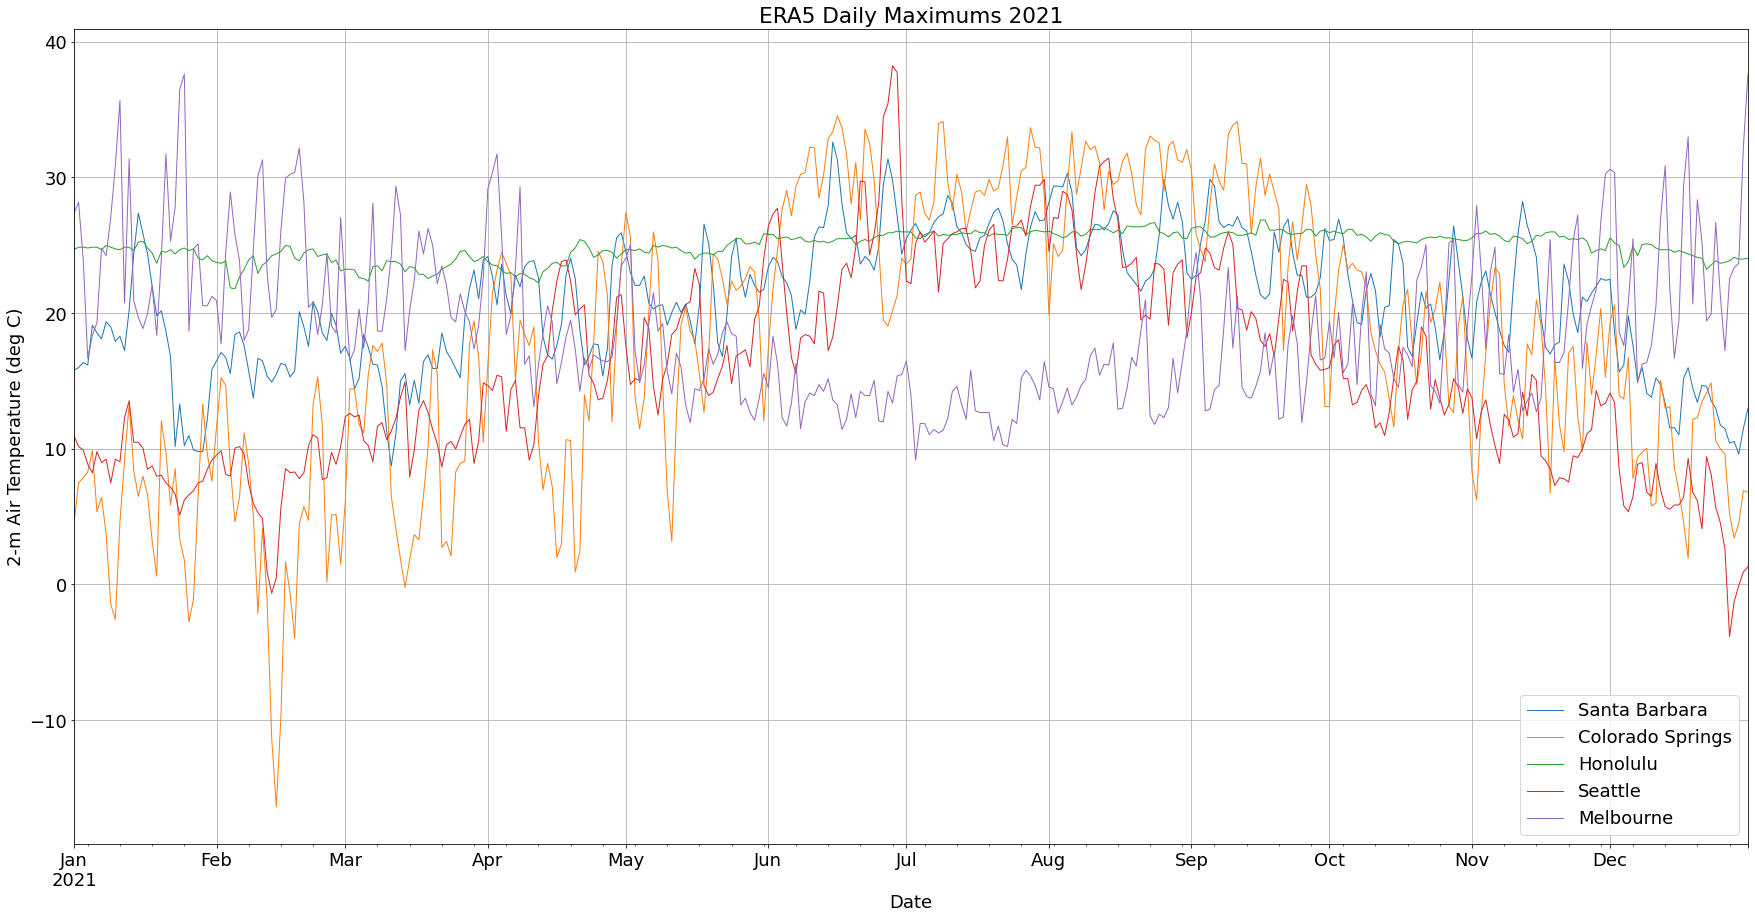

In [36]:
matplotlib.rcParams['lines.linewidth'] = 1.0
matplotlib.rcParams['lines.linestyle'] = 'solid'
ax = rs.plot(figsize=(30, 15), title="ERA5 Daily Maximums 2021", grid=1)
ax.set(xlabel='Date', ylabel='2-m Air Temperature (deg C)')
plt.show()

## Cluster scale down

When we are temporarily done with the cluster we can scale it down to save on costs

In [ ]:
numWorkers=0
ecs.update_service(cluster=cluster, service='Dask-Worker', desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Worker'])

Optional - stop the scheduler

In [ ]:
client.close()
ecs.update_service(cluster=cluster, service='Dask-Scheduler', desiredCount=0)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Scheduler'])